<a href="https://colab.research.google.com/github/donbowen/ClassNotes12pm-2025/blob/main/Inference_with_Nougat_to_read_scientific_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with Nougat to read scientific PDFs

In this notebook, we'll perform inference with Nougat, a Donut model trained by Meta AI to transcribe scientific PDFs into a common Markdown format. Docs for Nougat can be found [here](https://huggingface.co/docs/transformers/main/en/model_doc/nougat).

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/nougat_architecture.jpg"
alt="drawing" width="600"/>

<small> Nougat high-level overview. Taken from the <a href="https://arxiv.org/abs/2308.13418">original paper</a>. </small>

## Set-up environment

Let's start by installing 🤗 Transformers and [pymupdf](https://github.com/pymupdf/PyMuPDF), a library which we can use to read PDFs as images. We install Transformers from source here since the model is brand new at the time of writing.

We also install Levenshtein and NLTK as those are required for postprocessing.

In [1]:
!pip install -q pymupdf python-Levenshtein nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 99.4 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load model and processor

Next, we instantiate the model and its processor from the hub.

In [3]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    896,
    672
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0.dev0",
  "use_absolute_embeddings": false,
  "window_size": 7
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": tru

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

We also move the model to the GPU if it's available. I used "capture" below to avoid printing the entire model.

In [4]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

## Load PDF

Below we load a sample PDF, and then use the fitz module to turn it into a list of Pillow images (one for each page).

In [5]:
# from huggingface_hub import hf_hub_download

# filepath = hf_hub_download(repo_id="ysharma/nougat", filename="input/nougat.pdf", repo_type="space")
# print(filepath)

nougat.pdf:   0%|          | 0.00/4.13M [00:00<?, ?B/s]

/root/.cache/huggingface/hub/spaces--ysharma--nougat/snapshots/d06487a88e149a541a2803ea037f7a0bbd3b6c2c/input/nougat.pdf


In [6]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

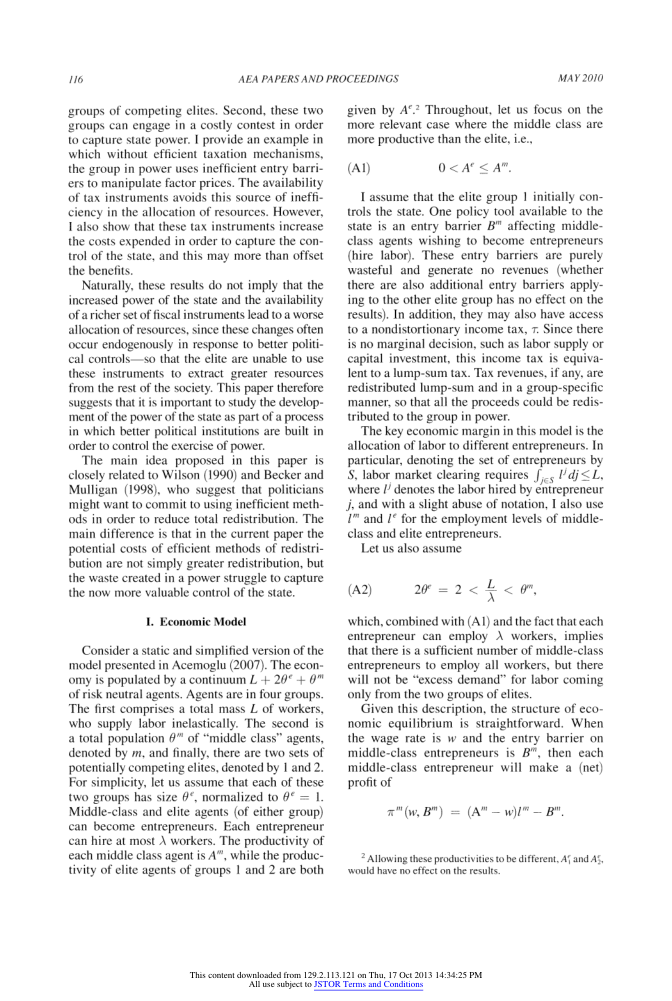

In [19]:
# load the pdf into images, and print a page for good measure

from PIL import Image

images = rasterize_paper(pdf="Acemoglu (2010) AER.pdf", return_pil=True)
image = Image.open(images[2])
image

## Generate transcription

Next, we let the model autoregressively generate the text appearning in the PDF. This is a lot faster on GPU than on CPU.

The authors did define some custom `StoppingCriteria`(which determine when the model should stop generating), so we're going to use them here as well.

In [22]:
# prepare image for the model

output = ''

for image in images:
  image = Image.open(image)

  pixel_values = processor(images=image, return_tensors="pt").pixel_values

  # autoregressively generate tokens, with custom stopping criteria (as defined by the Nougat authors)
  outputs = model.generate(pixel_values.to(device),
                            min_length=1,
                            max_length=3584,
                            bad_words_ids=[[processor.tokenizer.unk_token_id]],
                            return_dict_in_generate=True,
                            output_scores=True,
                            stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
  )

  generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
  generated = processor.post_process_generation(generated, fix_markdown=False)
  print(generated)
  output += ' ' + generated

<ipython-input-9-1f2d56ef631f>:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  return torch.var(self.values, 1) / self.values.shape[1]




## American Economic Association

**Institutions, Factor Prices, and Taxation: Virtues of Strong States?**

**Author(s): Daron Acemoglu**

**Source:** _The American Economic Review_**, Vol. 100, No. 2, PAPERS AND PROCEEDINGS OF THE One Hundred Twenty Second Annual Meeting OF THE AMERICAN ECONOMIC ASSOCIATION (May 2010), pp. 115-119**

**Published by: American Economic Association**

**Stable URL: http://www.jstor.org/stable/27804974**

**Accessed: 17/10/2013 14:34**

**Your use of the JSTOR archive indicates your acceptance of the Terms & Conditions of Use, available at**

**http://www.jstor.org/page/info/about/policies/terms.jsp**

**JSTOR is a not-for-profit service that helps scholars, researchers, and students discover, use, and build upon a wide range of content in a trusted digital archive. We use information technology and tools to increase productivity and facilitate new forms of scholarship. For more information about JSTOR, please contact support@jstor.org.**

**American Ec